In [11]:
import Pkg; Pkg.activate(@__DIR__)
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots
using BilinearControl
using TrajectoryOptimization
using JLD2
using BilinearControl.edmd

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [5]:
const datadir = joinpath(@__DIR__, "..", "data")
ref_traj = load(joinpath(datadir, "cartpole_reference_trajectory.jld2"))
X_sim = ref_traj["X_sim"][1:601]
U_sim = ref_traj["U_sim"][1:600]
T_sim = ref_traj["T_sim"][1:601]

601-element Vector{Float64}:
 0.0
 0.005
 0.01
 0.015
 0.02
 0.025
 0.03
 0.035
 0.04
 0.045
 0.05
 0.055
 0.06
 ⋮
 2.945
 2.95
 2.955
 2.96
 2.965
 2.97
 2.975
 2.98
 2.985
 2.99
 2.995
 3.0

In [6]:
const RD = RobotDynamics

RobotDynamics

In [7]:
function defcolor(c1, c2, c1def, c2def)
    if !isnothing(c1) && isnothing(c2)
        c2 = c1
    else
        c1 = isnothing(c1) ? c1def : c1
        c2 = isnothing(c2) ? c2def : c2
    end
    c1,c2
end

function set_mesh!(vis0, model::RobotZoo.Cartpole; 
        color=nothing, color2=nothing)
    vis = vis0["robot"]
    dim = Vec(0.1, 0.3, 0.1)
    rod = Cylinder(Point3f0(0,-10,0), Point3f0(0,10,0), 0.01f0)
    cart = Rect3D(-dim/2, dim)
    hinge = Cylinder(Point3f0(-dim[1]/2,0,dim[3]/2), Point3f0(dim[1],0,dim[3]/2), 0.03f0)
    c1,c2 = defcolor(color,color2, colorant"blue", colorant"red")

    pole = Cylinder(Point3f0(0,0,0),Point3f0(0,0,model.l),0.01f0)
    mass = HyperSphere(Point3f0(0,0,model.l), 0.05f0)
    setobject!(vis["rod"], rod, MeshPhongMaterial(color=colorant"grey"))
    setobject!(vis["cart","box"],   cart, MeshPhongMaterial(color=isnothing(color) ? colorant"green" : color))
    setobject!(vis["cart","hinge"], hinge, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["cart","pole","geom","cyl"], pole, MeshPhongMaterial(color=c1))
    setobject!(vis["cart","pole","geom","mass"], mass, MeshPhongMaterial(color=c2))
    settransform!(vis["cart","pole"], Translation(0.75*dim[1],0,dim[3]/2))
end

function visualize!(vis, model::RobotZoo.Cartpole, x::StaticVector)
    y = x[1]
    θ = x[2]
    q = expm((pi-θ) * @SVector [1,0,0])
    settransform!(vis["robot","cart"], Translation(0,-y,0))
    settransform!(vis["robot","cart","pole","geom"], LinearMap(UnitQuaternion(q)))
end

function visualize!(vis, model::RobotDynamics.AbstractModel, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    n = state_dim(model)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{n}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [8]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]
        
        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [9]:
# define temporal properties
dt = T_sim[2]-T_sim[1]
tf = T_sim[end]

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = X_sim[1]

# define Pendulum model
model = RobotZoo.Cartpole(1.0, 0.2, 0.5, 9.81)

state_dim(model) = 4
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

(4, 1, 4)

In [12]:
# determine eigenfunction state values
Z_sim, Zu_sim, z0 = build_eigenfunctions(X_sim, U_sim, ["state", "sine", "cosine"], [0, 0, 0])

# learn bilinear model
F, C, g = learn_bilinear_model(X_sim, Z_sim, Zu_sim, ["lasso", "lasso"]; edmd_weights=[0.0], mapping_weights=[0.0])

([0.9999999999997378 2.646819465357432e-12 … -6.728246122000759e-14 8.96045699794118e-16; 0.00011371926242653356 0.9991349513773032 … -1.1673149763984734e-5 8.196213959624674e-7; … ; -0.012091899658064481 0.24874939682402863 … 0.9840194268050438 -0.0003207380332589689; 5.793404927981014 -31.628345542616387 … 0.48832479098687104 0.9350875005585557], [1.7374746868898126e-13 -8.839796185359898e-13 … 1.2304280146696678e-14 -1.0159488121461238e-15; 3.197285580038254e-5 5.27572578048163e-5 … -9.694601306294691e-7 7.583730508260411e-8; … ; 0.03753427168497499 -0.09102992678025597 … 0.000446493940278236 5.88128588954793e-5; -0.7516078211511796 3.7514391429922544 … -0.03588800814569049 0.002141068622479806], [-1.0189374418158952e-13 1.0000000000003861 … -7.011732563639435e-15 -3.59297822277661e-16; -2.624138201270303e-15 9.61270404755444e-15 … -6.25505111941777e-16 6.755783496492187e-17; -1.3014561851735414e-14 5.762702008754493e-14 … -1.0466406024862441e-15 -3.4873020017853274e-16; -2.35361452

In [14]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim);

In [15]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/brian/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [16]:
visualize!(vis, model, tf, bi_X)

In [17]:
visualize!(vis, model, tf, X_sim)

In [18]:
# extract individual state histories
X_mat = mapreduce(permutedims, vcat, X_sim)'
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

cart_pos = X_mat[1, :]
pend_angle = X_mat[2, :]
cart_vel = X_mat[3, :]
pend_angular_vel = X_mat[4, :]

cart_pos_bilinear = bi_X_mat[1, :]
pend_angle_bilinear = bi_X_mat[2, :]
cart_vel_bilinear = bi_X_mat[3, :]
pend_angular_vel_bilinear = bi_X_mat[4, :]

601-element Vector{Float64}:
  0.0
 -0.035962531802011984
 -0.06916829708434961
 -0.09792594042465949
 -0.12352444986222146
 -0.17649109221083062
 -0.22195740632907424
 -0.2643968411674139
 -0.2982256292859333
 -0.3600706437228043
 -0.4122646538875711
 -0.4598961188838961
 -0.5006392294314402
  ⋮
  0.04572661419689685
  0.048226138341164085
  0.048832172464516696
  0.05212755485014837
  0.05472144713769689
  0.058342225035567435
  0.0606821467608229
  0.061971078444003895
  0.06379632453586091
  0.06529801080300388
  0.06873024237980337
  0.06912937861504477

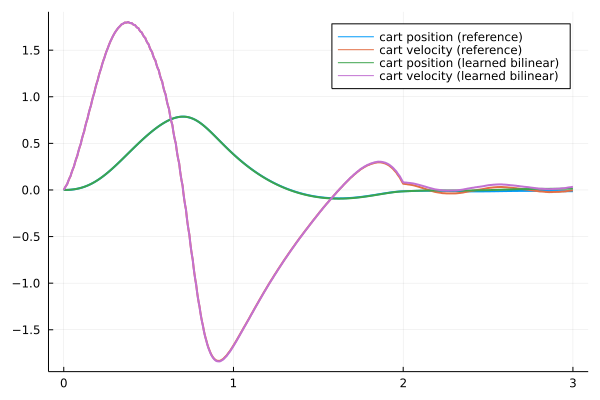

In [19]:
plot(T_sim, cart_pos, label = "cart position (reference)", lw = 2)
plot!(T_sim, cart_vel, label = "cart velocity (reference)",lw = 2)

plot!(T_sim, cart_pos_bilinear, label = "cart position (learned bilinear)", lw = 2)
plot!(T_sim, cart_vel_bilinear, label = "cart velocity (learned bilinear)", lw = 2)

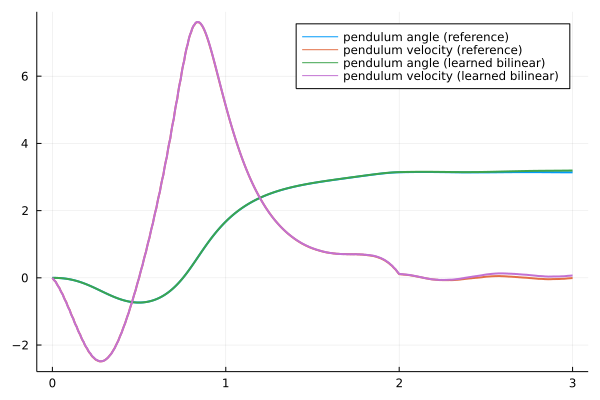

In [20]:
plot(T_sim, pend_angle, label = "pendulum angle (reference)", lw = 2)
plot!(T_sim, pend_angular_vel, label = "pendulum velocity (reference)",lw = 2)

plot!(T_sim, pend_angle_bilinear, label = "pendulum angle (learned bilinear)", lw = 2)
plot!(T_sim, pend_angular_vel_bilinear, label = "pendulum velocity (learned bilinear)", lw = 2)

In [22]:
using JLD2

save("../../data/cartpole_eDMD_data.jld2", "F", F, "C", C, "g", g, "X_sim", X_sim, "U_sim", U_sim)